In [1]:
# Load packages
#install.packages("tidymodels")
#install.packages("kknn")
library(tidyverse)
library(tidymodels)
library(recipes)
library(readxl)
library(gridExtra)
library(repr)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.2.0 ──

✔ broom        0.7.12     ✔ rsample      0.1.1 
✔ dials        0.1.0      ✔ tune         0.2.0 
✔ infer        1.0.0      ✔ workflows    0.2.6 
✔ modeldata    0.1.1      ✔ workflowsets 0.2.1 
✔ parsnip      0.2.1      ✔ yardstick    0.0.9 
✔ recipes      0.2.0      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filte

In [2]:
# set seed for reproducibility
set.seed(1234)
# load data; already split training and testing data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
data = download.file(url, destfile = "user.xls")
user_train = read_excel("user.xls", sheet = 2) %>%
            select(LPR, PEG, UNS) %>%
            mutate(UNS = as.factor(UNS))
user_test = read_excel("user.xls", sheet = 3) %>%
            select(LPR, PEG, UNS) %>%
            mutate(UNS = as.factor(UNS))
user_train$UNS <- recode_factor(user_train$UNS, very_low = "Very Low")
head(user_train)
head(user_test)

New names:
* `` -> ...7
* `` -> ...8

New names:
* `` -> ...7
* `` -> ...8



LPR,PEG,UNS
<dbl>,<dbl>,<fct>
0.00,0.00,Very Low
0.24,0.90,High
0.25,0.33,Low
0.65,0.30,Middle
0.98,0.24,Low
0.10,0.66,Middle


LPR,PEG,UNS
<dbl>,<dbl>,<fct>
0.26,0.05,Very Low
0.60,0.14,Low
0.60,0.85,High
0.67,0.85,High
0.30,0.90,High
0.50,0.30,Low


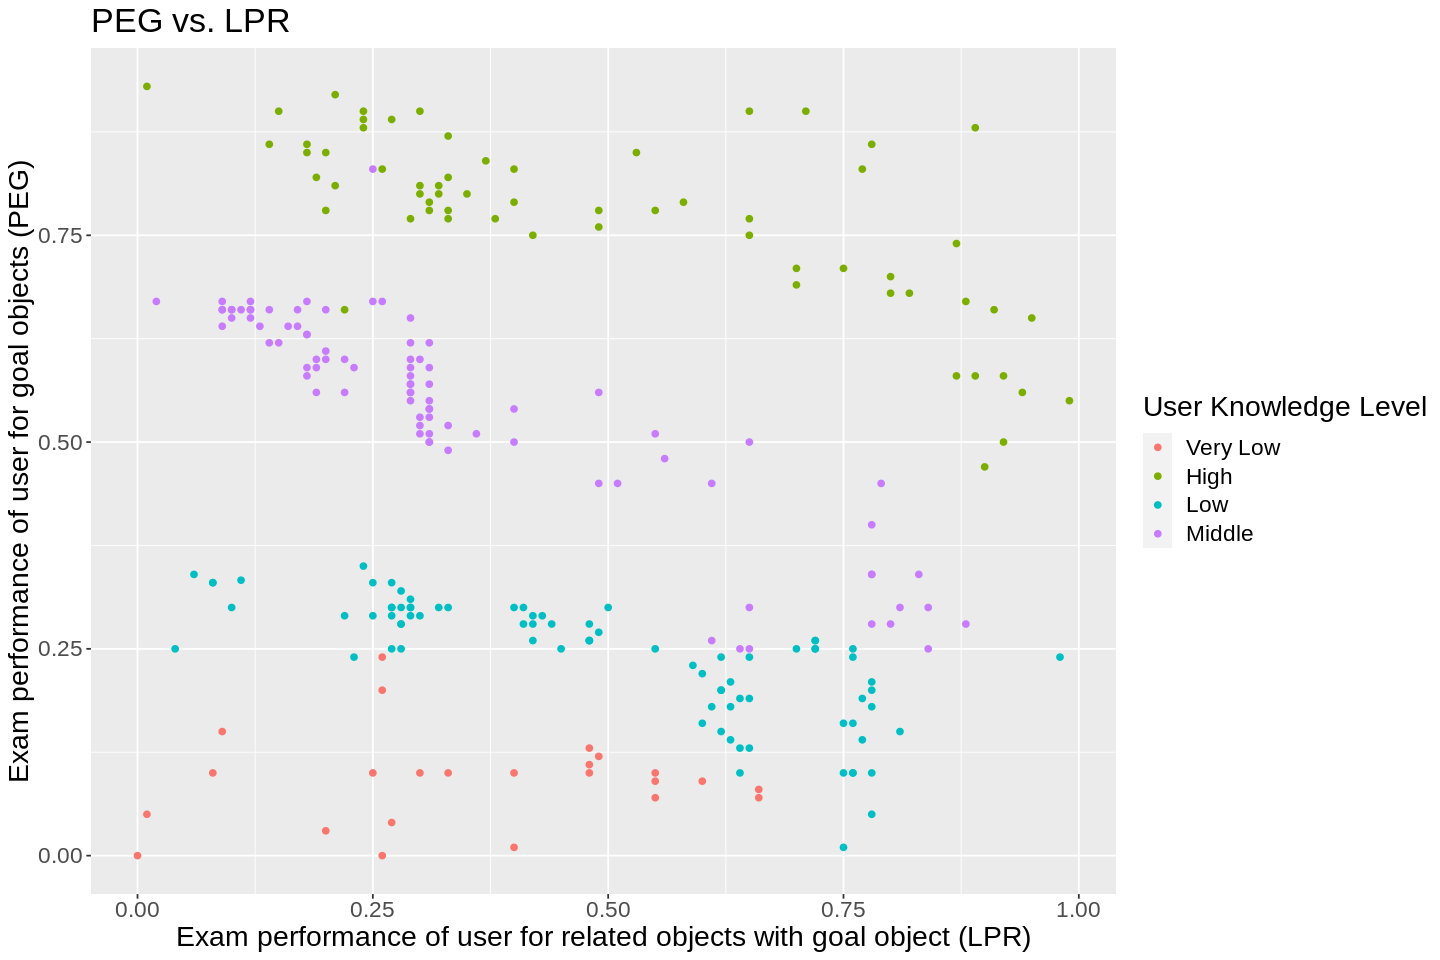

In [3]:
# visualizing training data
options(repr.plot.width = 12, repr.plot.height = 8) # for display
user_train_plot = user_train %>%
        ggplot(aes(x = LPR, y = PEG, colour = UNS)) +
        labs(x = "Exam performance of user for related objects with goal object (LPR)",y = "Exam performance of user for goal objects (PEG)", colour = 'User Knowledge Level') +
        ggtitle("PEG vs. LPR") +
        geom_point() +
        theme(text = element_text(size = 17))
user_train_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9496923,5,0.016714802,Preprocessor1_Model01
6,accuracy,multiclass,0.9498462,5,0.007538462,Preprocessor1_Model02
11,accuracy,multiclass,0.9460000,5,0.009279997,Preprocessor1_Model03
16,accuracy,multiclass,0.9187692,5,0.009145762,Preprocessor1_Model04
21,accuracy,multiclass,0.8683077,5,0.013908832,Preprocessor1_Model05
26,accuracy,multiclass,0.8567692,5,0.012591441,Preprocessor1_Model06


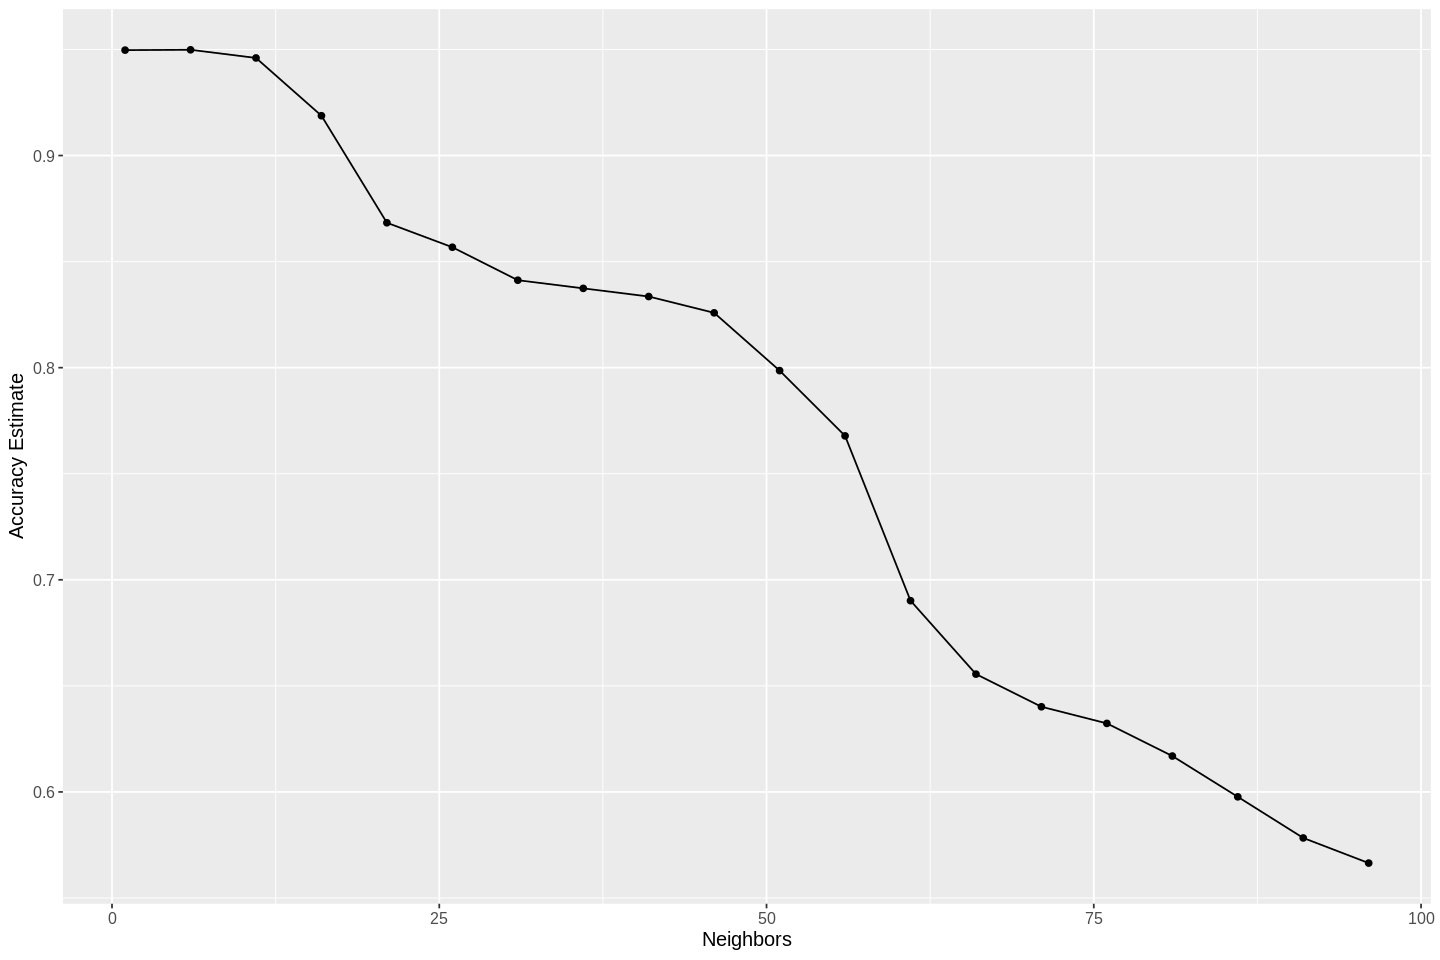

In [4]:
# prepare for data modelling for BOTH LPR AND PEG
user_recipe <- recipe(UNS ~ LPR + PEG , data = user_train)
# create classifier and using cross-validation for parameter value selection (K)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
# 5-fold cross-validation
user_vfold <- vfold_cv(user_train, v = 5, strata = "UNS")
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))
# train classifier with training data
user_results <- workflow() %>%
      add_recipe(user_recipe) %>%
      add_model(knn_spec) %>%
      tune_grid(user_vfold, grid = k_vals) %>%
      collect_metrics()
accuracies <- user_results %>%
      filter(.metric == "accuracy")
head(accuracies)
# look for K with highest accuracy
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y= mean)) +
      geom_point() + 
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") + 
      theme(text = element_text(size = 12))
accuracy_vs_k

In [5]:
# from accuracy_vs_k above, we see 6 is the best value for K
# final model with best value K
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
      set_engine("kknn") %>%
      set_mode("classification")

final_fit <- workflow() %>%
      add_recipe(user_recipe) %>%
      add_model(final_spec) %>%
      fit(data = user_train)

# predict labels for testing data
final_predictions <- predict(final_fit, user_test) %>%
      bind_cols(user_test)
head(final_predictions)
# keeping the values of levels in estimate and truth classes same
final_predictions$.pred_class <- factor(final_predictions$.pred_class, levels = c("High", "Low", "Middle", "Very Low"))
# find statistics about our model quality
final_metrics <- final_predictions %>%
      metrics(truth = UNS, estimate = .pred_class)
final_metrics
# confusion matrix for classifier
final_conf_mat <- final_predictions %>%
      conf_mat(truth = UNS, estimate = .pred_class)
final_conf_mat

.pred_class,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<fct>
Very Low,0.26,0.05,Very Low
Low,0.60,0.14,Low
High,0.60,0.85,High
High,0.67,0.85,High
High,0.30,0.90,High
Low,0.50,0.30,Low


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9724138
kap,multiclass,0.9626192


          Truth
Prediction High Low Middle Very Low
  High       39   0      0        0
  Low         0  45      1        2
  Middle      0   1     33        0
  Very Low    0   0      0       24

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4843077,5,0.014260053,Preprocessor1_Model01
6,accuracy,multiclass,0.5349231,5,0.003934373,Preprocessor1_Model02
11,accuracy,multiclass,0.5121538,5,0.019378509,Preprocessor1_Model03
16,accuracy,multiclass,0.5390769,5,0.021354157,Preprocessor1_Model04
21,accuracy,multiclass,0.5389231,5,0.013768156,Preprocessor1_Model05
26,accuracy,multiclass,0.5386154,5,0.016044317,Preprocessor1_Model06


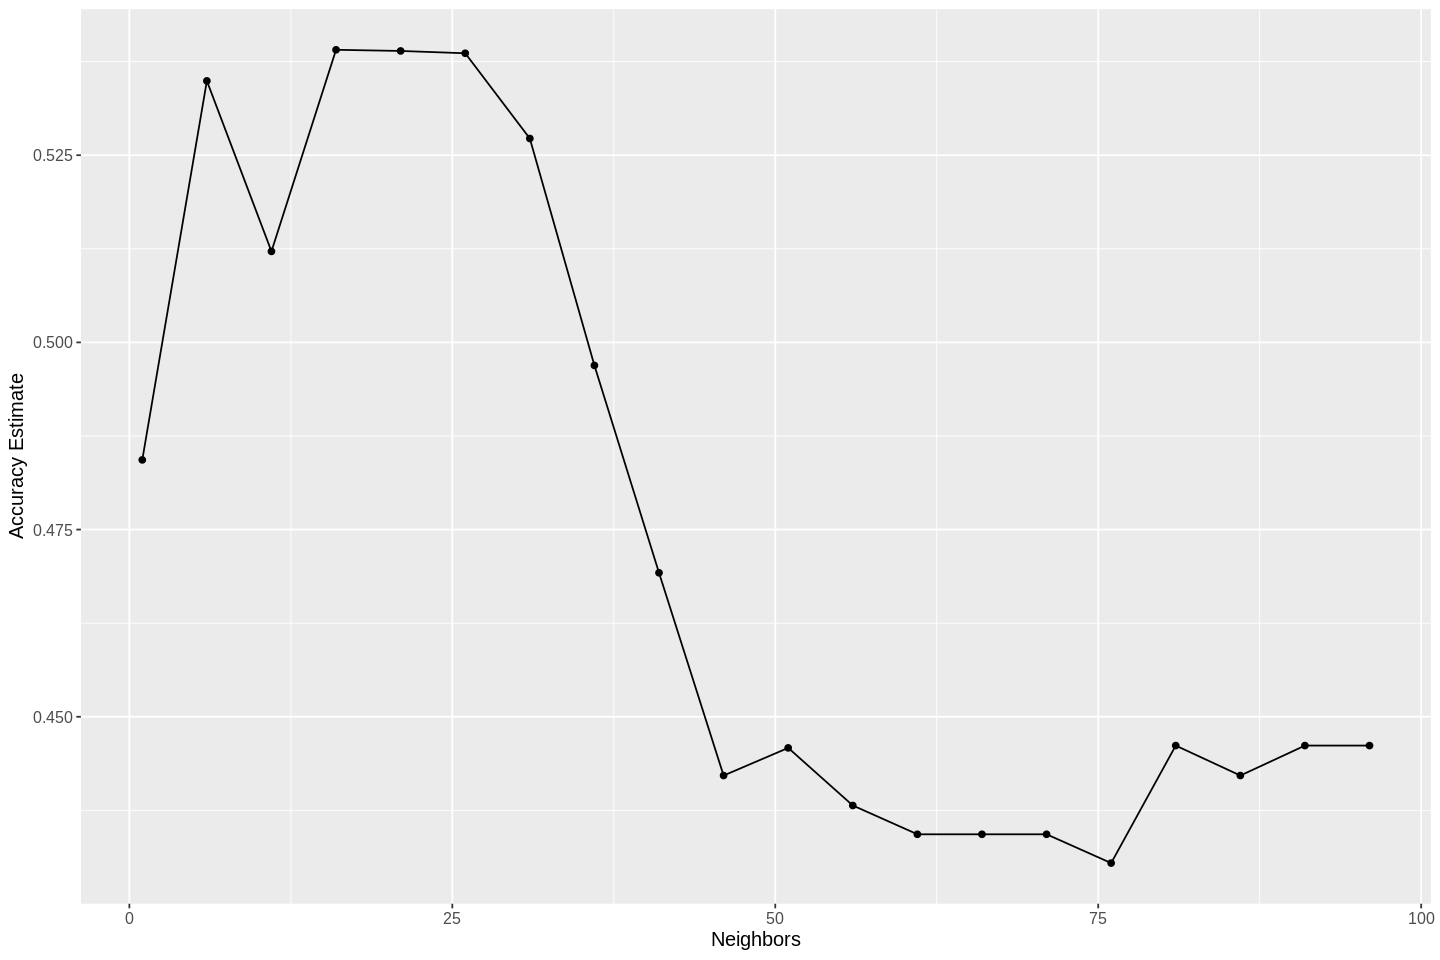

In [6]:
# prepare for data modelling for LPR ONLY
lpr_recipe <- recipe(UNS ~ LPR, data = user_train)
# create classifier and using cross-validation for parameter value selection (K)
lpr_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
# train classifier with training data
lpr_results <- workflow() %>%
      add_recipe(lpr_recipe) %>%
      add_model(lpr_knn_spec) %>%
      tune_grid(user_vfold, grid = k_vals) %>%
      collect_metrics()
lpr_accuracies <- lpr_results %>%
      filter(.metric == "accuracy")
head(lpr_accuracies)
# look for K with highest accuracy
lpr_accuracy_vs_k <- ggplot(lpr_accuracies, aes(x = neighbors, y= mean)) +
      geom_point() + 
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") + 
      theme(text = element_text(size = 12))
lpr_accuracy_vs_k

In [7]:
# from accuracy_vs_k above, we see 16 is the best value for K
# final model with best value K
final_lpr_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) %>%
      set_engine("kknn") %>%
      set_mode("classification")

final_lpr_fit <- workflow() %>%
      add_recipe(lpr_recipe) %>%
      add_model(final_lpr_spec) %>%
      fit(data = user_train)

# predict labels for testing data
final_lpr_predictions <- predict(final_lpr_fit, user_test) %>%
      bind_cols(user_test)
head(final_lpr_predictions)
# keeping the values of levels in estimate and truth classes same
final_lpr_predictions$.pred_class <- factor(final_lpr_predictions$.pred_class, levels = c("High", "Low", "Middle", "Very Low"))
# find statistics about our model quality
final_lpr_metrics <- final_lpr_predictions %>%
      metrics(truth = UNS, estimate = .pred_class)
final_lpr_metrics
# confusion matrix for classifier
final_lpr_conf_mat <- final_lpr_predictions %>%
      conf_mat(truth = UNS, estimate = .pred_class)
final_lpr_conf_mat

.pred_class,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<fct>
Low,0.26,0.05,Very Low
Low,0.60,0.14,Low
Low,0.60,0.85,High
Low,0.67,0.85,High
Middle,0.30,0.90,High
Low,0.50,0.30,Low


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.28965517
kap,multiclass,0.02500326


          Truth
Prediction High Low Middle Very Low
  High       13  10      6        4
  Low        12  16     15        8
  Middle     14  20     13       14
  Very Low    0   0      0        0

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8140000,5,0.02144540,Preprocessor1_Model01
6,accuracy,multiclass,0.8293846,5,0.01141576,Preprocessor1_Model02
11,accuracy,multiclass,0.8452308,5,0.01777472,Preprocessor1_Model03
16,accuracy,multiclass,0.8413846,5,0.01912958,Preprocessor1_Model04
21,accuracy,multiclass,0.8333846,5,0.01659757,Preprocessor1_Model05
26,accuracy,multiclass,0.8295385,5,0.01630080,Preprocessor1_Model06


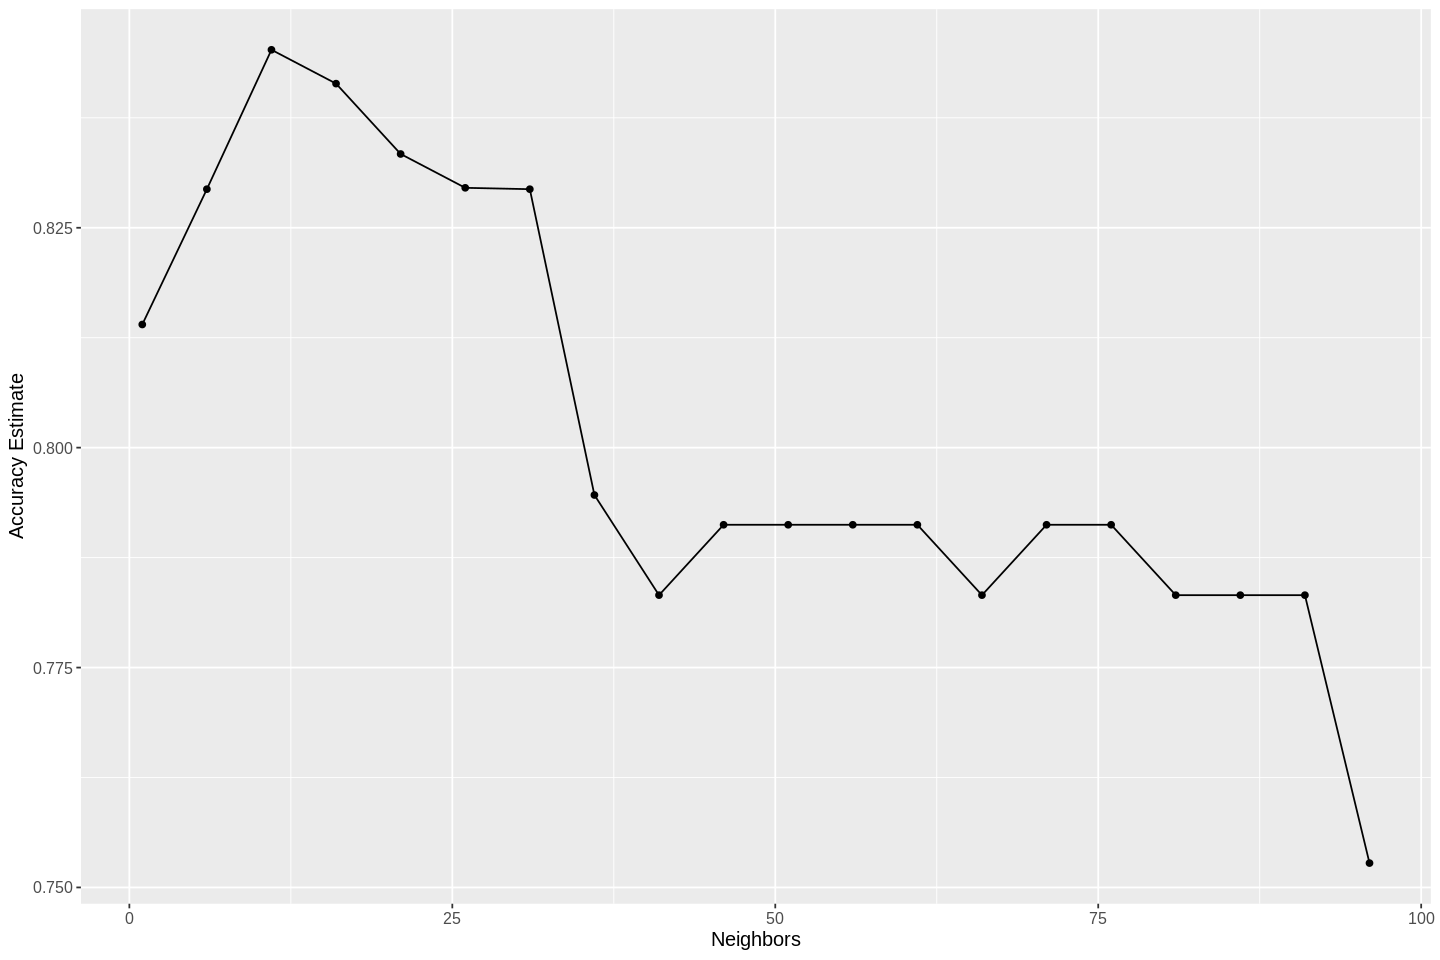

In [8]:
# prepare for data modelling for PEG ONLY
peg_recipe <- recipe(UNS ~ PEG, data = user_train)
# create classifier and using cross-validation for parameter value selection (K)
peg_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
# train classifier with training data
peg_results <- workflow() %>%
      add_recipe(peg_recipe) %>%
      add_model(peg_knn_spec) %>%
      tune_grid(user_vfold, grid = k_vals) %>%
      collect_metrics()
peg_accuracies <- peg_results %>%
      filter(.metric == "accuracy")
head(peg_accuracies)
# look for K with highest accuracy
peg_accuracy_vs_k <- ggplot(peg_accuracies, aes(x = neighbors, y= mean)) +
      geom_point() + 
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") + 
      theme(text = element_text(size = 12))
peg_accuracy_vs_k

In [9]:
# from accuracy_vs_k above, we see 11 is the best value for K
# final model with best value K
final_peg_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
      set_engine("kknn") %>%
      set_mode("classification")

final_peg_fit <- workflow() %>%
      add_recipe(peg_recipe) %>%
      add_model(final_peg_spec) %>%
      fit(data = user_train)

# predict labels for testing data
final_peg_predictions <- predict(final_peg_fit, user_test) %>%
      bind_cols(user_test)
head(final_peg_predictions)
# keeping the values of levels in estimate and truth classes same
final_peg_predictions$.pred_class <- factor(final_peg_predictions$.pred_class, levels = c("High", "Low", "Middle", "Very Low"))
# find statistics about our model quality
final_peg_metrics <- final_peg_predictions %>%
      metrics(truth = UNS, estimate = .pred_class)
final_peg_metrics
# confusion matrix for classifier
final_peg_conf_mat <- final_peg_predictions %>%
      conf_mat(truth = UNS, estimate = .pred_class)
final_peg_conf_mat

.pred_class,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<fct>
Very Low,0.26,0.05,Very Low
Low,0.60,0.14,Low
High,0.60,0.85,High
High,0.67,0.85,High
High,0.30,0.90,High
Low,0.50,0.30,Low


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8689655
kap,multiclass,0.8208713


          Truth
Prediction High Low Middle Very Low
  High       35   0      0        0
  Low         0  45      9        5
  Middle      4   1     25        0
  Very Low    0   0      0       21